In [19]:
# Please run on Colab

import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

# Offline Asynchronous Filter
- Collect raw data from H3
- Post-process the data with Exponential Filter
- Calculate the shift

In [20]:
def EXPN(dt,al):
    """
    Attenuate high frequency noise with exponential filter

    Parameters:
    dt (list of nums): original data
    al (float): filter parameter

    Returns:
    list of numbers: filtered data
    """
    temp = 0
    fil = []
    for d in dt:
        f = al*d + (1 - al)*temp
        fil.append(f)
        temp = f
    return fil

In [21]:
def AVG(ls):
    """
    Calculate the average of lists of numbers in a list

    Parameters:
    ls (list of lists of nums): input list

    Returns:
    list of nums: average of the lists of nums
    """
    s = np.zeros(len(ls[0]))
    for l in ls:
        s += np.array(l)
    s /= len(ls)
    return list(s)

def StoF(st):
    """
    Convert a list of string to a list of float

    Parameters:
    st (list of string): input list

    Returns:
    list of float: converted from input list

    """
    ls = []
    for s in st:
        ls.append(float(s))
    return ls

def RMSE(fil,unfil):
    """
    Calculate Root Mean Sqaure Error while aligning filtered datat with original data

    Parameters:
    fil (list of nums): filtered data
    unfil(list of nums): unfiltered data

    Returns:
    list of nums: list of RMSE of each alignment
    """
    lse = []
    for i in range(len(unfil)):
        y = fil[i:]
        N = y.shape[0]
        x = unfil[0:N]
        e = (np.sum((y - x)**2)/N)**.5
        lse.append(e)
    return lse

In [22]:
def SHIFT(dt,al):
    """
    Print and plot the shift of filtered data based on unfiltered data

    Parameters:
    dt (list of nums): original data
    al (float): filter parameter

    Returns:
    None
    """
    plt.rcParams["figure.figsize"] = (8,3)
    plt.plot(dt)
    m = min(dt)
    shift = dt.index(m)
    plt.plot(shift,m,"ro")
    plt.ylim(0,1)
    plt.xlim(0,10)
    plt.title(f"alpha = {al}")
    T = 1/100
    fc = al/((1 - al)*2*np.pi*T)
    print(f"shift: {shift}, RMSE: {round(m,4)}, cutoffL {round(fc,1)}")

In [23]:
# read data
file_path = "h3Data4.txt"
# Open the file in read mode
with open(file_path, "r") as file:
    # Read the contents of the file
    filecontent = file.read()
content = filecontent.split("\n")[0:-2]
t = range(2001)
data = []
for con in content:
    data.append(StoF(con[1:-1].split(",")))
sensor = data[:6]
ref = data[6]
ls_al = [.1,.2,.4,.6,.8]

In [24]:
exp = []
for s in sensor:
    lse = []
    for a in ls_al:
        lse.append(EXPN(s,a))
    exp.append(lse)

In [25]:
arr = []
for idx in range(len(sensor)):
    dt = exp[idx]
    unfil = np.array(sensor[idx])
    lsrmse = []
    for d in dt:
        fil = np.array(d)
        rmse = RMSE(fil,unfil)
        lsrmse.append(rmse)
    arr.append(lsrmse)

In [26]:
al_1 = []
for s in arr:
    al_1.append(s[0])
    avg1 = AVG(al_1)
al_2 = []
for s in arr:
    al_2.append(s[1])
    avg2 = AVG(al_2)
al_3 = []
for s in arr:
    al_3.append(s[2])
    avg3 = AVG(al_3)
al_4 = []
for s in arr:
    al_4.append(s[3])
    avg4 = AVG(al_4)
al_5 = []
for s in arr:
    al_5.append(s[4])
    avg5 = AVG(al_5)

shift: 8, RMSE: 0.2989, cutoffL 1.8


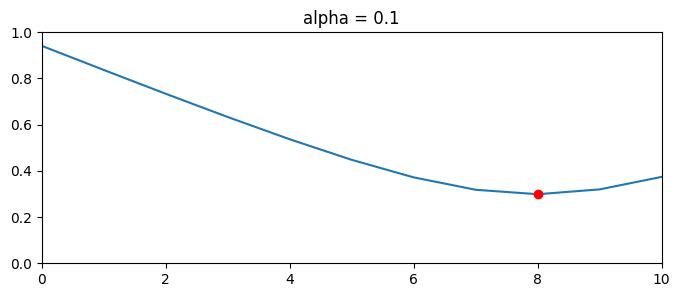

shift: 4, RMSE: 0.1324, cutoffL 4.0


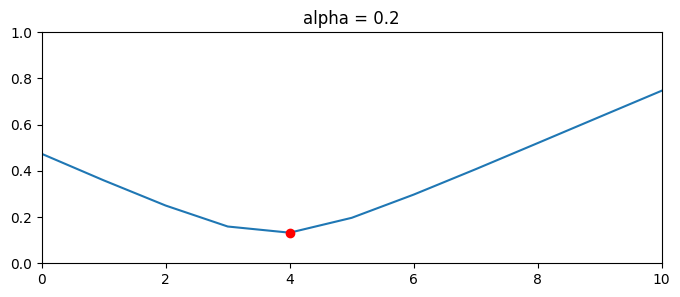

shift: 1, RMSE: 0.0932, cutoffL 10.6


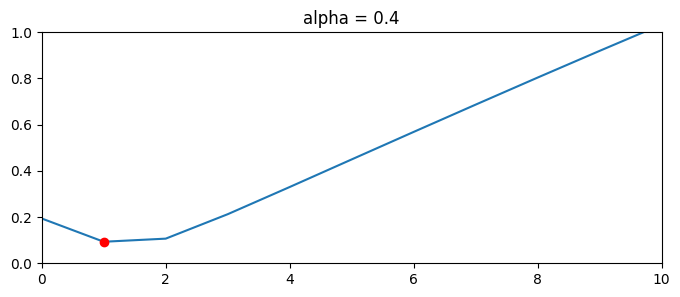

shift: 1, RMSE: 0.0861, cutoffL 23.9


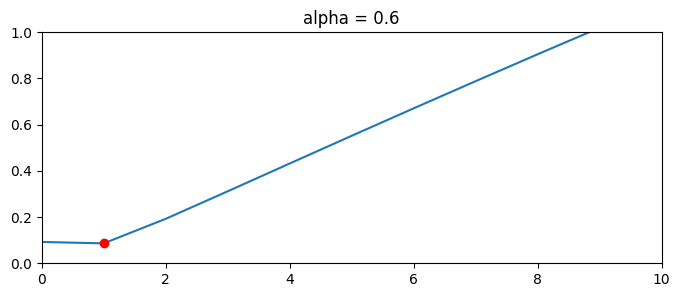

shift: 0, RMSE: 0.0376, cutoffL 63.7


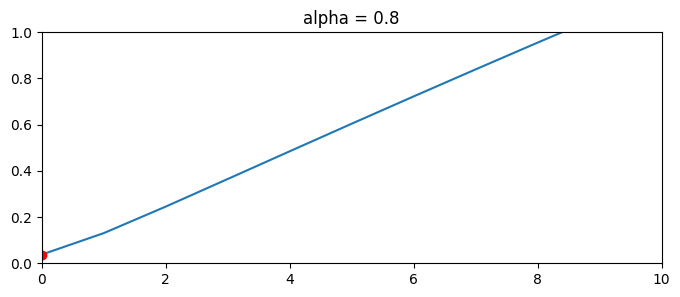

In [27]:
ls_avg = [avg1,avg2,avg3,avg4,avg5]
for i in range(len(ls_al)):
    al = ls_al[i]
    dt = ls_avg[i]
    SHIFT(dt,al)
    plt.show()

# Real-time Synchronous Filter
- Record real-time filtered data as well as neccessary data to generate Bode plot from H3

In [ ]:
def Bode(sig_in,sig_out,Fs = 100):
    """
    Generate Bode plot

    Parameters:
    sig_in (list of nums): input signal
    sig_out (list of nums): output signal
    Fs (int): sampling frequency

    Returns:
    numpy array: frequency
    numpy array: amplitude in dB
    numpy array: phase change in deg
    """
    L = len(sig_in)
    NFFT = 2**math.ceil(math.log2(L))
    f = (Fs / 2) * np.linspace(0, 1, NFFT // 2 + 1)
    Yin = np.fft.fft(sig_in, NFFT)
    Yin = Yin[:NFFT // 2 + 1]
    Y = np.fft.fft(sig_out, NFFT)
    Y = Y[:NFFT // 2 + 1]
    OutImp_BodeAm_dB = 20 * np.log10(np.abs(Y / Yin))
    OutImp_BodePh = np.angle(Y / Yin, deg=True)
    window_size = 50
    OutBand_BodeAm_dB = pd.Series(OutImp_BodeAm_dB).rolling(window=window_size, min_periods=1).mean()
    OutBand_BodePh = pd.Series(OutImp_BodePh).rolling(window=window_size, min_periods=1).mean()

    OutBand_BodeAm_dB = OutBand_BodeAm_dB.to_numpy()
    OutBand_BodePh = OutBand_BodePh.to_numpy()
    return f,OutBand_BodeAm_dB,OutBand_BodePh

In [28]:
# read data
file_path = "h3Data5_1.txt"
# Open the file in read mode
with open(file_path, "r") as file:
    # Read the contents of the file
    filecontent = file.read()
content = filecontent.split("\n")
t = range(6001)
dT = 1/100

In [29]:
data = []
for i in range(len(content)):
    c = content[i].split("]")[:-2]
    entry = []
    for j in range(len(c)):
        if j == 0:
            row = c[j][2:].split(",")
        else:
            row = c[j][3:].split(",")
        for r in row:
            entry.append(float(r))
    data.append(entry)

In [30]:
ndata = np.array(data)
dt = np.reshape(ndata,(6,4,6001))

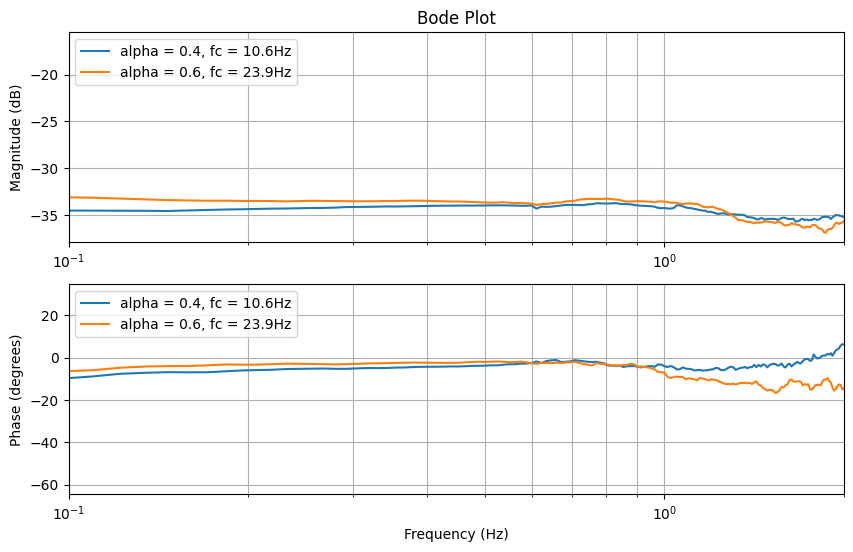

In [31]:
lsf = []
lsa = []
lsd = []

for i in range(len(dt)):
    fil = dt[i][1]
    vel = dt[i][3]
    f,a,d = Bode(fil,vel)
    lsf.append(f)
    lsa.append(a)
    lsd.append(d)


freq4 = sum(lsf[:3])/3
amp4 = sum(lsa[:3])/3
deg4 = sum(lsd[:3])/3
freq6 = sum(lsf[3:])/3
amp6 = sum(lsa[3:])/3
deg6 = sum(lsd[3:])/3


label = ["alpha = 0.4, fc = 10.6Hz","alpha = 0.6, fc = 23.9Hz"]

# Plot the Bode plot
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.semilogx(freq4, amp4)
plt.semilogx(freq6, amp6)
plt.xlim(0.1,2)
plt.ylabel('Magnitude (dB)')
plt.grid(which='both', axis='both')
plt.legend(label,loc="upper left")
plt.title("Bode Plot")

plt.subplot(2, 1, 2)
plt.semilogx(freq4, deg4)
plt.semilogx(freq6, deg6)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (degrees)')
plt.xlim(0.1,2)
plt.grid(which='both', axis='both')
plt.legend(label,loc="upper left")

plt.show()

In [40]:
# Individual Plot
def indPlot(trial):
    """
    Generate Bode plot and comparison of filtered and unfilered data of chosen trial from 0~5
    """
    fr,am,de = Bode(dt[trial][1],dt[trial][3])
    unfil = dt[trial][0]
    fil = dt[trial][1]
    if trial > 2:
        alpha = .6
    else:
        alpha = .4

    plt.figure(figsize=(12, 6))
    plt.subplot(3, 1, 1)
    plt.semilogx(fr, am)
    plt.xlim(0.1,2)
    plt.ylabel('Magnitude (dB)')
    plt.grid(which='both', axis='both')
    plt.title(f"Bode Plot: trial {trial+1}, alpha {alpha}")

    plt.subplot(3, 1, 2)
    plt.semilogx(fr, de)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Phase (degrees)')
    plt.xlim(0.1,2)
    plt.grid(which='both', axis='both')

    plt.subplot(3,1,3)
    plt.plot(t,unfil,"-r")
    plt.plot(t,fil,"-b")
    plt.ylabel("Torque (Nm)")
    plt.xlabel("Timestamp")
    plt.legend(["unfiltered","filtered"],loc="lower left")

    plt.show()

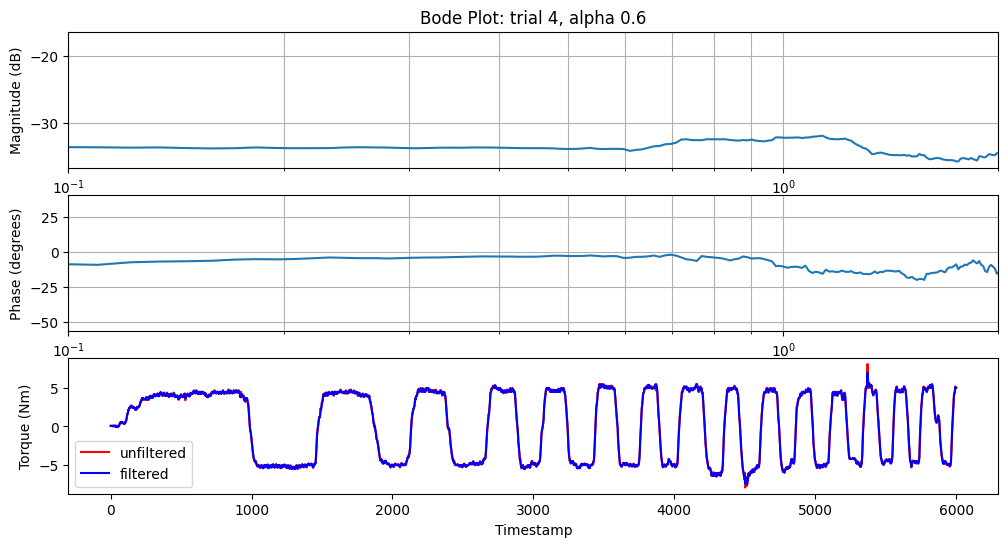

In [41]:
indPlot(3)